In [200]:
#ephemeris sim
using LinearAlgebra
#make sure to cite this package
using SPICE
using Downloads: download 
using DifferentialEquations
using Plots

In [201]:
# Load leap seconds kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 
furnsh("/home/fausto/naif0012.tls")

In [202]:
# Convert the calendar date to ephemeris seconds past J2000

#was 2018
et = utc2et("2024-02-06T20:45:00")

7.605243691849185e8

In [203]:
# Load a planetary ephemeris kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#laptop
furnsh("/home/fausto/de440.bsp")

In [204]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [205]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [206]:
#get the jacobian that maps from rotating frame to inertial frame
function get_transformation(time)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    C = [x̃ ỹ z̃]

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)

    θ_dot = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]


    return C, θ_dot

end

get_transformation (generic function with 1 method)

In [207]:
function cr3bp_to_ephem(x, t)

    time = et + t

    #get transformation takes in time wrt et
    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    #apply the rotation to get the state in the inertial frame
    x_ephem = C̃*x

    return x_ephem

end

cr3bp_to_ephem (generic function with 1 method)

In [208]:
function ephem_dynamics_scaled!(du, u, p, t)
    
    #scaled version
    du[1:6] = scaled_ephemeris_dynamics(u[1:6], t)
    
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [209]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [210]:
function just_dynamics_integrate_scaled(x_0, period)
    
    #integrate from 0 to period
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [211]:
#the state is in km and s as well as the time

function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    

    #println("position of the satellite: ", r_qi)

    #println("position of the moon: ", rqj_moon)

    rij_moon = rqj_moon- r_qi 

    #println("vector from satellite to moon: ", rij_moon)

    #println("distance to moon : ", norm(rij_moon))

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));


    #display((-μ_e/(norm(r_qi))^3)*r_qi)

    #display(μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3)))
                
    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [212]:
#ephemeris_model_EarthMoon(x_test_ephem, 0)

In [213]:
sat_pose = [-361607.2624380957, -282246.2472476799, -75773.60247125119]
moon_pose = [-305665.5295916485, -238568.75389771274, -64082.58948032478]


3-element Vector{Float64}:
 -305665.5295916485
 -238568.75389771274
  -64082.58948032478

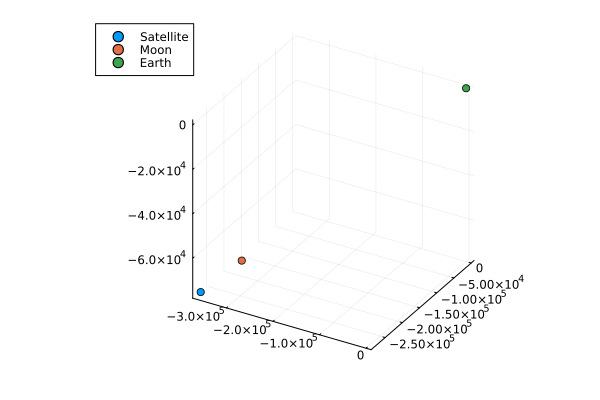

In [214]:
#these dynamics are all relative to the Earth
scatter([sat_pose[1]], [sat_pose[2]], [sat_pose[3]], label="Satellite")
scatter!([moon_pose[1]], [moon_pose[2]], [moon_pose[3]], label= "Moon")
scatter!([0], [0], [0], label = "Earth")

In [216]:
#the x is scaled here as well as the t 

function scaled_ephemeris_dynamics(x,t)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)

    #get to original units (km and s)
    q_original = x[1:3]*l_star 
    v_original = x[4:6]*(l_star/t_star)
    t_original = t*t_star

    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = ephemeris_model_EarthMoon(x_original, t_original)
    
    #then scale the output
    v_scaled = ẋ_original[1:3]/(l_star/t_star)
    
    a_scaled = ẋ_original[4:6]/(l_star/(t_star)^2)

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

scaled_ephemeris_dynamics (generic function with 1 method)

In [217]:
L_cr = 3.850e5 #in km - distance between centers of m1 and m2
V_cr = 1.025 #in km/s - orbital velocity of m1
T_cr = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_cr/(2*pi)

375764.8206399649

In [218]:
L_nasa = 389703
T_nasa = 382981

382981

In [219]:
#mass paramter for earth moon
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [220]:
#position of Earth in rotating frame
pose_m1 = [-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 -0.01215058560962404
  0.0
  0.0

In [221]:
x0_test = [1.1201297302380415,
 0.0,
 0.0059396759100811495,
 0.0,
 0.17677819141944426,
 0.0]

 x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

 #in cr3bp units 
T_periodic = 3.414975413662902

x0_dim = [x0_test_earthcentered[1:3]*L_cr; x0_test_earthcentered[4:6]*(L_cr/T_cr)]

T_dim = T_periodic*time_scale

1.2832276238049301e6

In [222]:
################################################################################################################
#from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

#in nasa cr3bp units
#x0_test = [1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18]
#T_periodic = 3.4155308065628454

#larger orbit
# x0_test = [1.1805068248439281E+0,	-3.3114436259161434E-27,	1.9906874796338979E-2,	3.3672394329658290E-15,	-1.5811356683023692E-1, 2.2436379855191516E-15]
# T_periodic = 3.1503862907153901
# x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]


# x0_dim = [x0_test_earthcentered[1:3]*L_nasa; x0_test_earthcentered[4:6]*(L_nasa/T_nasa)]

# T_dim = T_periodic*T_nasa
#################################################################################################################

In [223]:
x_test_ephem = cr3bp_to_ephem(x0_dim, 0)

6-element Vector{Float64}:
   35677.75392672705
 -383227.521788774
 -204700.13822902984
       1.1169697806195908
       0.09462041520675622
       0.017536997176863373

In [224]:
ephemeris_model_EarthMoon(x_test_ephem, 0)

6-element Vector{Float64}:
  1.1169697806195908
  0.09462041520675622
  0.017536997176863373
 -2.713532502393513e-7
  2.9214119061117146e-6
  1.5206806829616711e-6

In [225]:
x_test_ephem_scaled = [x_test_ephem[1:3]/l_star; x_test_ephem[4:6]/(l_star/t_star)]

T_ephem_scaled = T_dim/t_star

3.403027188305123

In [226]:

sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, T_ephem_scaled)

all_states = get_state(sol)

6×45 Matrix{Float64}:
  0.0925031   0.113115    0.131606   …   0.592024   0.496082   0.477873
 -0.993609   -0.99167    -0.9896         1.55421    1.6532     1.67103
 -0.530734   -0.53031    -0.529759       0.807134   0.863123   0.873238
  1.09204     1.08999     1.08788       -0.578229  -0.59141   -0.593403
  0.0925086   0.112787    0.130899       0.624405   0.583718   0.576402
  0.0171456   0.0277084   0.0371551  …   0.35222    0.331007   0.32718

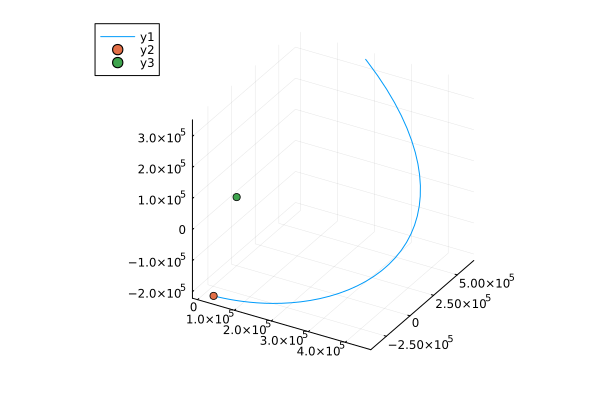

In [227]:
plot(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])

In [228]:
#problem: gravity of the moon is much lower than the gravity of Earth 

In [229]:
using DelimitedFiles
xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

#in days
time_steps = readdlm("time.txt", '\t', Float64, '\n')
#period 
T_periodic_n = 3.414975413662902

3.414975413662902

In [230]:
#units of km and days

In [231]:
xtraj

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [232]:
μ_earth_moon*L_cr 

4677.975459705256

In [233]:
xtraj

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [234]:
xtraj_transformed = [xtraj[1:3, :].+ [4677.975459705256, 0, 0]; xtraj[4:6, :]./86400]

6×131 Matrix{Float64}:
    4.35928e5     4.35928e5      4.35928e5   …     4.35928e5       4.35928e5
    0.0           2.11866        4.21631        -974.27           -0.00385146
 2286.77       2286.77        2286.77           2285.38         2286.77
    0.0           3.48459e-7     6.93463e-7       -0.00016129      2.54541e-8
    0.181123      0.181123       0.181123          0.181029        0.181123
    0.0          -1.12034e-6    -2.22958e-6  …     0.000515089     1.49752e-9

In [235]:
#make sure to divide by 86400 to get into seconds

In [236]:
time_steps[2]

0.00013538610115700251

In [237]:
time_steps

131×1 Matrix{Float64}:
  0.0
  0.00013538610115700251
  0.00026942994704742514
  0.0004303715711435791
  0.0006830964153669305
  0.0009491675045592131
  0.001277070628775285
  0.0016106543976025993
  0.0019878701330316474
  0.0024459945807384777
  ⋮
 13.87688676653883
 14.013485059891314
 14.148023074242456
 14.28247964970406
 14.41397369914275
 14.543371472173106
 14.66737869572139
 14.789903469175059
 14.852171558441775

In [239]:
#transform each of these points into the Earth Moon ephemeris model to see what it looks like

xtraj_ephemeris = zeros(6,131)

x_centered = xtraj_ephemeris 

for i=1:131

    xtraj_ephemeris[:,i] = cr3bp_to_ephem(xtraj_transformed[:,i], time_steps[i]*86400)
end

In [240]:
xtraj_ephemeris

6×131 Matrix{Float64}:
 35677.8        35694.3        …  -2.09314e5  -2.20785e5  -2.26536e5
    -3.83228e5     -3.83226e5      3.32859e5   3.26974e5   3.23875e5
    -2.047e5       -2.047e5        1.88262e5   1.85423e5   1.83914e5
     1.2687         1.26871       -0.980154   -0.963538   -0.954567
     0.107474       0.107517      -0.486669   -0.510792   -0.522757
     0.0199193      0.0199409  …  -0.233207   -0.247887   -0.255206

In [241]:
[all_states[1:3, :].*l_star; all_states[4:6,:].*(l_star/t_star)] 

6×45 Matrix{Float64}:
 35677.8        43627.5        50759.4        …       1.91335e5   1.84312e5
    -3.83228e5     -3.8248e5      -3.81681e5          6.37628e5   6.44505e5
    -2.047e5       -2.04537e5     -2.04324e5     332900.0         3.36801e5
     1.11697        1.11487        1.11271           -0.604911   -0.60695
     0.0946204      0.115362       0.133887           0.597043    0.58956
     0.017537       0.028341       0.0380033  …       0.338564    0.334649

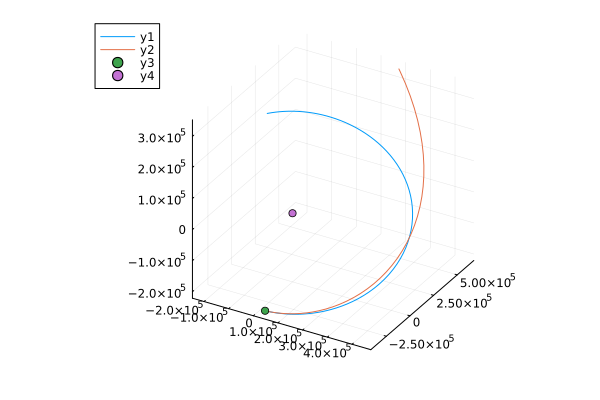

In [242]:
plot(xtraj_ephemeris[1,:], xtraj_ephemeris[2,:], xtraj_ephemeris[3,:])

plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])